## Imports

In [1]:
import math

import numpy as np
from pycircstat.tests import rayleigh
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

from sherlock_helpers.constants import DATA_DIR, FIG_DIR, GRID_SCALE
from sherlock_helpers.functions import add_arrows, show_source

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Set plotting params

In [2]:
STEP = 1.2
THRESH = 0.05
cmap = plt.cm.Spectral
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [3]:
avg_recall_events = np.load(DATA_DIR.joinpath('avg_recall_events.npy'))
mappings = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)
embeddings = np.load(DATA_DIR.joinpath('embeddings.npy'), allow_pickle=True)
episode_embedding, avg_recall_embedding, recall_embeddings = embeddings

## Define/inspect some functions/classes

In [4]:
show_source(add_arrows)

In [5]:
class Point:
    def __init__(self, coord=None):
        self.coord = np.array(coord)

In [6]:
class LineSegment:  
    def __init__(self, p1=None, p2=None):
        if not isinstance(p1, Point):
            p1 = Point(p1)
        if not isinstance(p2, Point):
            p2 = Point(p2)
        
        self.p1 = p1
        self.p2 = p2
        self.vec = self.p2.coord - self.p1.coord
        self.norm = self.vec / np.linalg.norm(self.vec)
    
    @property
    def angle(self):
        p1 = np.zeros_like(self.get_p1())
        p2 = np.zeros_like(self.get_p1())
        p2[0] = 1
        ref = LineSegment(p1, p2)
        return self.angle_with(ref)
    
    def get_p1(self):
        return self.p1.coord
    
    def get_p2(self):
        return self.p2.coord
        
    def intersects(self, z):
        if isinstance(z, Circle):
            return _seg_intersect_circle(self, z)
        elif isinstance(x, Rectangle):
            return _seg_intersect_rect(self, z)
        
    def angle_with(self, ref):
        assert isinstance(ref, LineSegment)
        v0 = ref.vec
        v1 = self.vec
        angle = np.arccos(v0.dot(v1) / (np.linalg.norm(v0) * np.linalg.norm(v1)))
        if self.vec[1] < 0:
            angle = (2 * np.pi) - angle
            
        return angle

In [7]:
class Circle:
    def __init__(self, center=None, r=None):
        self.center = np.array(center)
        self.r = r 
    
    def get_center(self):
        return self.center
    
    def get_radius(self):
        return self.r

In [8]:
def _seg_intersect_circle(ls, circ):
    Q = circ.get_center()
    r = circ.get_radius()
    P1 = ls.get_p1()
    V = ls.get_p2() - P1
    
    a = V.dot(V)
    b = 2 * V.dot(P1 - Q)
    c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r ** 2
    
    disc = b ** 2 - 4 * a * c
    if disc < 0:
        return False
    
    sqrt_disc = math.sqrt(disc)
    t1 = (-b + sqrt_disc) / (2 * a)
    t2 = (-b - sqrt_disc) / (2 * a)
    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return False
    
    return True

In [9]:
def compute_coord(xi, yi, w, seglist, kind='rectangle'):
    if kind=='rectangle':
        z = Rectangle(x=xi, y=yi, w=w)
    elif kind=='circle':
        z = Circle(center=[xi,yi], r=w)
        
    segs = list(filter(lambda s: s.intersects(z), seglist))
    c = len(segs)
    if c > 1:
        u, v  = np.array([seg.norm for seg in segs]).mean(0)
        rads = np.array([seg.angle for seg in segs])
        p, z = rayleigh(rads)
    else:
        u = 0
        v = 0
        p = 1
        z = 0
        
    return u, v, p, c, z

In [10]:
def plot_embedding_flow(ax, cmap='Spectral', **kwargs):
    color = M.reshape(M.shape[0] * M.shape[1], 4)
    ax.quiver(X, Y, U, V, color=color, zorder=1, width=.004)
    ax.plot(avg_recall_embedding[:, 0], avg_recall_embedding[:, 1], zorder=2, c='k', alpha=.5)
    add_arrows(ax, 
               avg_recall_embedding[:, 0], 
               avg_recall_embedding[:, 1], 
               zorder=3, 
               alpha=1, 
               color='k', 
               fill=True)
    ax.scatter(avg_recall_embedding[:, 0], 
               avg_recall_embedding[:, 1], 
               c=range(avg_recall_embedding.shape[0]), 
               cmap=cmap, 
               s=150, 
               zorder=4)
    ax.scatter(avg_recall_embedding[:, 0], 
               avg_recall_embedding[:, 1], 
               c='k', 
               cmap=cmap, 
               s=200,
               zorder=3)
    for sub_emb in recall_embeddings:
        ax.plot(sub_emb[:, 0], sub_emb[:, 1], zorder=1, c='k', alpha=.02)
    
    ax.set_xlim(-20, 21)
    ax.set_ylim(-17, 23)
    ax.set_aspect('equal')
    ax.axis('off')

    return ax

In [11]:
def add_circle(xy, radius, ax, color='blue', alpha=0.5, linewidth=2, linestyle='solid', fill=True, **kwargs):
    facecolor = mpl.colors.to_rgba(color, alpha)
    circle = plt.Circle(xy, radius=radius, facecolor=facecolor, edgecolor='k', lw=linewidth, ls=linestyle, 
                        fill=fill, transform=ax.transData, zorder=4, **kwargs)
    ax.add_patch(circle)
    return ax

In [12]:
def plot_rayleigh(x_ix, y_ix, circle, ax, color='b', alpha=0.3, bin_degrees=20, **kwargs):
    segs = [s for s in seglist if s.intersects(circle)]
    if len(segs) > 0:        
        thetas = np.array([s.angle for s in segs])
        bins = np.deg2rad(np.arange(0, 360 + bin_degrees, bin_degrees))
        bincounts, *_ = ax.hist(thetas, bins=bins, color=color, alpha=alpha, **kwargs)

        u, v = np.mean([s.norm for s in segs], axis=0)
        arrow = LineSegment((0, 0), (u, v))
        arrow_len = np.linalg.norm(arrow.vec) * bincounts.max()
        angle_transform = mpl.transforms.Affine2D().translate(arrow.angle, 0) + ax.transData
        arrow_color = M[x_ix, y_ix]
        if not np.array_equal(arrow_color, np.array([0.5, 0.5, 0.5, 0.25])):
            arrow_color = mpl.colors.to_rgba(color, 1)

        edgecolor = mpl.colors.to_rgba('k', arrow_color[3])
        ax.arrow(0, 0, 0, arrow_len, 
                 width=0.15, head_width=0.4, length_includes_head=True, 
                 facecolor=arrow_color, edgecolor=edgecolor, linewidth=1,
                 transform=angle_transform)
        ax.set_rlabel_position(0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    return arrow.angle

In [13]:
def plot_flow_around(x_ix, 
                     y_ix,
                     colors='grey',
                     alpha=1,
                     bg_color='blue', 
                     bg_alpha=0.2,
                     plot_average=True,
                     arrows=False,
                     ax=None,
                     rayleigh_ax=None, 
                     flow_ax=None, 
                     circle_kwargs=None,
                     arrow_kwargs=None,
                     rayleigh_kwargs=None, 
                     flow_kwargs=None, 
                     **kwargs):
    if ax is None:
        ax = plt.gca()

    x = X[x_ix, y_ix]
    y = Y[x_ix, y_ix]
    z = Z[x_ix, y_ix]
    pc = Pc[x_ix, y_ix]
    
    radius = STEP * 2
    circle = Circle(center=(x, y), r=radius)
    if circle_kwargs is None:
        circle_kwargs = dict()
        
    facecolor = mpl.colors.to_rgba(bg_color, alpha=bg_alpha)
    clip_circle = plt.Circle(circle.center, 
                             radius=circle.r, 
                             facecolor=facecolor, 
                             linewidth=2,
                             edgecolor=(0, 0, 0, 1), 
                             fill=True, 
                             transform=ax.transData, 
                             **circle_kwargs)
    try:
        sns.color_palette(colors)
        c = 'k'
        is_palette = True
    except ValueError:
        c = colors
        is_palette = False
        
    if arrows and arrow_kwargs is None:
        arrow_kwargs = dict()
        
    intersect_counts = list()
    for sub_emb in recall_embeddings:
        sub_intersects = 0
        for i in range(len(sub_emb) - 1):
            seg = LineSegment(Point(sub_emb[i]), Point(sub_emb[i+1]))
            if seg.intersects(circle):
                ax.plot(sub_emb[i:i+2, 0], 
                        sub_emb[i:i+2, 1], 
                        c=c, 
                        alpha=alpha, 
                        clip_path=clip_circle, 
                        zorder=3,
                        **kwargs)
                if arrows:
                    add_arrows(ax, 
                               sub_emb[i:i+2, 0], 
                               sub_emb[i:i+2, 1], 
                               color=c, 
                               alpha=alpha, 
                               zorder=3,
                               **arrow_kwargs)
                sub_intersects += 1
                
        if sub_intersects > 0:
            intersect_counts.append(sub_intersects)
        
    if is_palette:
        lines = ax.get_lines()
        line_ix = 0
        palette = sns.color_palette(colors, len(intersect_counts))
        for n, c in zip(intersect_counts, palette):
            for _ in range(n):
                lines[line_ix].set_color(c)
                line_ix += 1
        
    if plot_average:
        ax.plot(avg_recall_embedding[:, 0],
                avg_recall_embedding[:, 1], 
                c='k', 
                linewidth=4, 
                clip_path=clip_circle, 
                zorder=2,
                **kwargs)
        if arrows:
            add_arrows(ax, 
                       avg_recall_embedding[:, 0],
                       avg_recall_embedding[:, 1], 
                       color='k', 
                       zorder=2,
                       **arrow_kwargs)
        
    if arrows:
        for a in ax.artists:
            a.set_clip_path(clip_circle)
            
    ax.add_patch(clip_circle)
    ax.set_xlim(x - radius, x + radius)
    ax.set_ylim(y - radius, y + radius)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if flow_ax is not None:
        if flow_kwargs is None:
            flow_kwargs = dict()
            
        add_circle((x, y), radius=radius, color=bg_color, ax=flow_ax, **flow_kwargs)
    
    if rayleigh_ax is not None:
        assert isinstance(rayleigh_ax.properties()['xaxis'], mpl.projections.polar.ThetaAxis)
        if rayleigh_kwargs is None:
            rayleigh_kwargs = dict()
            
        mean_angle = plot_rayleigh(x_ix, y_ix, circle, color=bg_color, ax=rayleigh_ax, **rayleigh_kwargs)

    return mean_angle, z, pc

## Set up embedding components

In [14]:
# create 2D grid
X, Y = np.meshgrid(np.arange(-GRID_SCALE, GRID_SCALE, STEP), 
                   np.arange(-GRID_SCALE, GRID_SCALE, STEP))

# create list of line segments from individual recall embeddings
seglist = []
for sub in recall_embeddings:
    for i in range(sub.shape[0] - 1):
        p1 = Point(coord=sub[i, :])
        p2 = Point(coord=sub[i + 1, :])
        seg = LineSegment(p1=p1, p2=p2)
        seglist.append(seg)
        
# compute avg vector and p-value at each grid point
U = np.zeros_like(X)
V = np.zeros_like(X)
P = np.zeros_like(X)
Z = np.zeros_like(X)
C = np.zeros_like(X)

pbar = tqdm(total=len(X)**2, leave=False)
for i, (x, y) in enumerate(zip(X, Y)):
    for j, (xi, yi) in enumerate(zip(x, y)):
        U[i, j], V[i, j], P[i, j], C[i, j], Z[i, j] = compute_coord(xi, yi, 
                                                                    STEP * 2, 
                                                                    seglist, 
                                                                    kind='circle')
        pbar.update()
pbar.close()

Pc = multipletests(P.ravel(), method='fdr_bh', alpha=THRESH)[1].reshape(P.shape)
M = np.hypot(U, V)
M = plt.cm.Blues(M)
M[Pc > THRESH] = [.5, .5, .5, .25]
M[P == 1] = [.5, .5, .5, 0]

## Plot

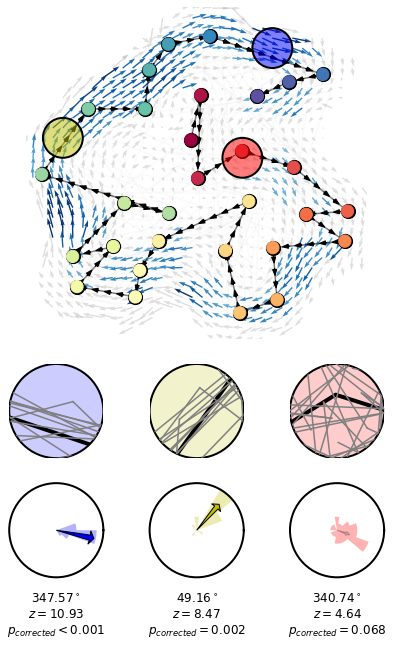

In [15]:
fig = plt.figure(figsize=(6, 9))
gs = fig.add_gridspec(5, 3)
flow_ax = fig.add_subplot(gs[:3, :])

zoom_ax1 = fig.add_subplot(gs[3, 0])
polar_ax1 = fig.add_subplot(gs[4, 0], polar=True)

zoom_ax2 = fig.add_subplot(gs[3, 1])
polar_ax2 = fig.add_subplot(gs[4, 1], polar=True)

zoom_ax3 = fig.add_subplot(gs[3, 2])
polar_ax3 = fig.add_subplot(gs[4, 2], polar=True)

arrow_kwargs = {
    'aspace': 0.6,
    'head_width': 0.2
}

plot_embedding_flow(flow_ax)
angle1, z1, pc1 = plot_flow_around(40, 33, bg_color='b', arrow_kwargs=arrow_kwargs, 
                                   ax=zoom_ax1, rayleigh_ax=polar_ax1, flow_ax=flow_ax)
angle2, z2, pc2 = plot_flow_around(31, 12, bg_color='y', arrow_kwargs=arrow_kwargs, 
                                   ax=zoom_ax2, rayleigh_ax=polar_ax2, flow_ax=flow_ax)
angle3, z3, pc3 = plot_flow_around(29, 30, bg_color='r', arrow_kwargs=arrow_kwargs, 
                                   ax=zoom_ax3, rayleigh_ax=polar_ax3, flow_ax=flow_ax)

polar_axes = (polar_ax1, polar_ax2, polar_ax3)
angles = (angle1, angle2, angle3)
zs = (z1, z2, z3)
pcs = (pc1, pc2, pc3)

max_bincount = int(max([b.get_height() for ax in polar_axes for b in ax.patches]))
for i, ax in enumerate(polar_axes):
    ax.set_rlim(0, max_bincount)
    ax.set_rticks([max_bincount])
    ax.set_xticks([])
    ax.spines['polar'].set_linewidth(2)
    angle = f'{round(np.rad2deg(angles[i]), 2)}^\circ'
    z = f'z = {round(zs[i], 2)}'
    if pcs[i] < 0.001:
        pc = 'p_{corrected} < 0.001'
    else:
        pc = 'p_{corrected} = %s' % round(pcs[i], 3)
    ax.text(0.5, -0.6, 
            f"${angle}$\n${z}$\n${pc}$",
            fontsize='large', ha='center', transform=ax.transAxes)
    

gs.tight_layout(fig, h_pad=2.5)
# plt.savefig(FIG_DIR.joinpath('topic_space_flow.pdf'))
plt.show()